In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from collections import Counter

# Set plotting styles
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📚 Libraries loaded successfully!")


📚 Libraries loaded successfully!


In [30]:
# Load the Truth Social posts data
print("📊 Loading Truth Social posts data...")

# Load the main dataset
df = pd.read_csv('../data/truth_social_posts_final_2025_cleaned.csv')
df['date_parsed'] = pd.to_datetime(df['date_parsed'])

print(f"✅ Loaded {len(df):,} posts")
print(f"📅 Date range: {df['date_parsed'].min()} to {df['date_parsed'].max()}")

# Filter posts with text content
text_df = df[df['content_text'].notna() & (df['content_text'].str.len() > 0)].copy()
print(f"📝 Posts with text content: {len(text_df):,}")

# Define target words to analyze
TARGET_WORDS = ["Joe", "Epstein"]
print(f"🎯 Target words for analysis: {TARGET_WORDS}")

# Show data structure
text_df.head()


📊 Loading Truth Social posts data...
✅ Loaded 3,477 posts
📅 Date range: 2025-01-01 10:48:00 to 2025-07-20 20:53:00
📝 Posts with text content: 1,885
🎯 Target words for analysis: ['Joe', 'Epstein']


,speaker,handle,platform,post_url,content_text,image_url,deleted_flag,content_links,date_parsed,is_retweet,is_media_only
0,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Adam “Shifty” Schiff is in BIG TROUBLE! He fal...,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 20:53:00,False,False
2,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Go get the GREAT NEW BOOK by Mark Levin. It’s ...,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 20:06:00,False,False
4,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,HOW DID SAMANTHA POWER MAKE ALL OF THAT MONEY???,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 19:56:00,False,False
6,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Watch Mark Levin on FoxNews! NOW!!!,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 19:53:00,False,False
15,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,“Greatest Bitcoin explanation of all time”,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 18:50:00,False,False


In [31]:
def find_word_occurrences(text, word, context_chars=100):
    """
    Find all occurrences of a word in text with surrounding context
    
    Args:
        text: Text to search in
        word: Word to search for (case-insensitive)
        context_chars: Number of characters to include before/after the word for context
    
    Returns:
        List of dictionaries with occurrence details
    """
    if pd.isna(text) or text == '':
        return []
    
    text = str(text)
    occurrences = []
    
    # Use regex for case-insensitive word boundary matching
    pattern = r'\b' + re.escape(word) + r'\b'
    matches = list(re.finditer(pattern, text, re.IGNORECASE))
    
    for match in matches:
        start = max(0, match.start() - context_chars)
        end = min(len(text), match.end() + context_chars)
        context = text[start:end].strip()
        
        # Highlight the matched word in context
        highlighted_context = re.sub(
            pattern, 
            f'**{match.group()}**', 
            context, 
            flags=re.IGNORECASE
        )
        
        occurrences.append({
            'word': match.group(),
            'position': match.start(),
            'context': context,
            'highlighted_context': highlighted_context
        })
    
    return occurrences

def analyze_word_in_dataset(df, word):
    """
    Analyze occurrences of a word throughout the dataset
    
    Args:
        df: DataFrame with 'content_text' and 'date_parsed' columns
        word: Word to analyze
    
    Returns:
        Dictionary with analysis results
    """
    print(f"🔍 Analyzing word: '{word}'...")
    
    results = {
        'word': word,
        'total_occurrences': 0,
        'posts_with_word': 0,
        'occurrences_per_post': [],
        'posts_data': [],
        'daily_counts': {},
        'monthly_counts': {},
        'contexts': []
    }
    
    for idx, row in df.iterrows():
        occurrences = find_word_occurrences(row['content_text'], word)
        
        if occurrences:
            results['posts_with_word'] += 1
            results['total_occurrences'] += len(occurrences)
            results['occurrences_per_post'].append(len(occurrences))
            
            # Store post data
            post_data = {
                'date': row['date_parsed'],
                'speaker': row['speaker'],
                'content': row['content_text'],
                'occurrences': len(occurrences),
                'contexts': occurrences
            }
            results['posts_data'].append(post_data)
            
            # Count by date
            date_str = row['date_parsed'].date()
            month_str = row['date_parsed'].strftime('%Y-%m')
            
            results['daily_counts'][date_str] = results['daily_counts'].get(date_str, 0) + len(occurrences)
            results['monthly_counts'][month_str] = results['monthly_counts'].get(month_str, 0) + len(occurrences)
            
            # Store contexts
            results['contexts'].extend(occurrences)
    
    print(f"✅ Found {results['total_occurrences']} occurrences in {results['posts_with_word']} posts")
    
    return results

print("🔧 Word analysis functions defined!")


🔧 Word analysis functions defined!


In [32]:
# Analyze each target word
print("🎯 Running analysis on target words...")
print("="*50)

word_analyses = {}
for word in TARGET_WORDS:
    word_analyses[word] = analyze_word_in_dataset(text_df, word)
    print()

# Summary statistics
print("📊 SUMMARY STATISTICS:")
print("="*50)
for word, analysis in word_analyses.items():
    print(f"\n🔤 Word: '{word}'")
    print(f"   Total occurrences: {analysis['total_occurrences']}")
    print(f"   Posts containing word: {analysis['posts_with_word']}")
    print(f"   Percentage of posts: {analysis['posts_with_word']/len(text_df)*100:.2f}%")
    if analysis['occurrences_per_post']:
        print(f"   Average occurrences per post: {np.mean(analysis['occurrences_per_post']):.2f}")
        print(f"   Max occurrences in single post: {max(analysis['occurrences_per_post'])}")

print(f"\n📈 Analysis complete for {len(TARGET_WORDS)} words!")


🎯 Running analysis on target words...
🔍 Analyzing word: 'Joe'...
✅ Found 96 occurrences in 70 posts

🔍 Analyzing word: 'Epstein'...
✅ Found 20 occurrences in 12 posts

📊 SUMMARY STATISTICS:

🔤 Word: 'Joe'
   Total occurrences: 96
   Posts containing word: 70
   Percentage of posts: 3.71%
   Average occurrences per post: 1.37
   Max occurrences in single post: 6

🔤 Word: 'Epstein'
   Total occurrences: 20
   Posts containing word: 12
   Percentage of posts: 0.64%
   Average occurrences per post: 1.67
   Max occurrences in single post: 6

📈 Analysis complete for 2 words!


📈 Creating timeline visualizations with fixed monthly alignment...
📅 Months found in data: ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07']


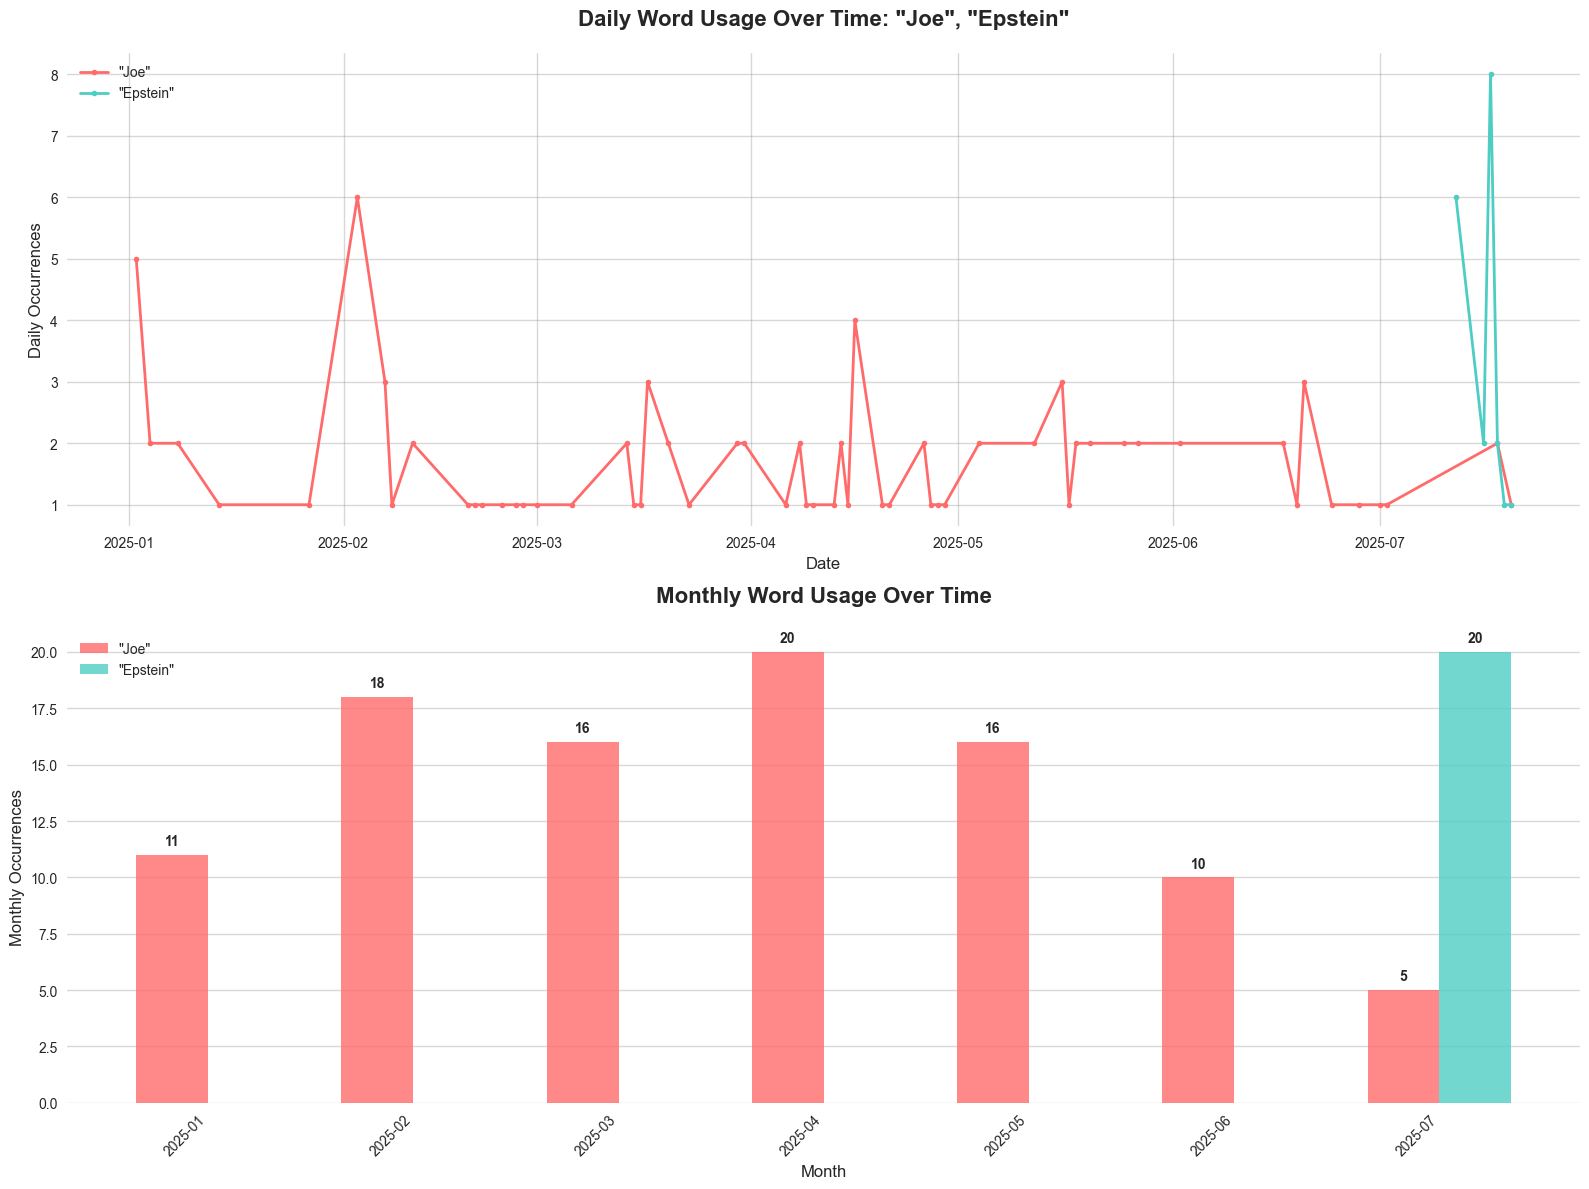

✅ FIXED Timeline visualization created and saved!
🔧 Monthly bars now correctly aligned to calendar months


In [33]:
# Create timeline visualizations (FIXED)
print("📈 Creating timeline visualizations with fixed monthly alignment...")

def create_timeline_plot_fixed(word_analyses):
    """Create comprehensive timeline plots for word usage with FIXED monthly alignment"""
    
    # Prepare data for plotting
    daily_data = {}
    
    for word, analysis in word_analyses.items():
        if analysis['daily_counts']:
            daily_dates = [pd.to_datetime(date) for date in analysis['daily_counts'].keys()]
            daily_counts = list(analysis['daily_counts'].values())
            daily_data[word] = pd.DataFrame({
                'date': daily_dates,
                'count': daily_counts
            }).sort_values('date')
    
    if not daily_data:
        print("⚠️ No timeline data to plot")
        return False
    
    # FIXED: Create unified monthly data structure aligned to calendar months
    # Get all months that appear in the dataset
    all_months = set()
    monthly_data_by_word = {}
    
    for word, analysis in word_analyses.items():
        monthly_data_by_word[word] = {}
        if analysis['monthly_counts']:
            for month_str, count in analysis['monthly_counts'].items():
                all_months.add(month_str)
                monthly_data_by_word[word][month_str] = count
    
    # Sort all months chronologically
    sorted_months = sorted(list(all_months))
    print(f"📅 Months found in data: {sorted_months}")
    
    # Create matplotlib figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    # Daily timeline (unchanged)
    if daily_data:
        for i, (word, data) in enumerate(daily_data.items()):
            ax1.plot(data['date'], data['count'], 
                    label=f'"{word}"',
                    color=colors[i % len(colors)],
                    marker='o', linewidth=2, markersize=4)
    
    ax1.set_facecolor('none')
    title_words = ", ".join([f'"{w}"' for w in TARGET_WORDS])
    ax1.set_title(f'Daily Word Usage Over Time: {title_words}', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Daily Occurrences', fontsize=12)
    ax1.legend()
    ax1.grid(True, color='gray', alpha=0.3)
    
    # FIXED: Monthly timeline with proper calendar alignment
    if sorted_months:
        bar_width = 0.35
        month_positions = np.arange(len(sorted_months))  # Positions for each month
        
        for i, word in enumerate(TARGET_WORDS):
            # Create counts array aligned to all months (fill missing with 0)
            word_counts = []
            for month in sorted_months:
                count = monthly_data_by_word.get(word, {}).get(month, 0)
                word_counts.append(count)
            
            # Calculate bar positions (offset for multiple words)
            x_positions = month_positions + (i * bar_width)
            
            bars = ax2.bar(x_positions, word_counts, bar_width,
                          label=f'"{word}"',
                          color=colors[i % len(colors)],
                          alpha=0.8)
            
            # Add value labels on bars
            for bar, count in zip(bars, word_counts):
                if count > 0:
                    ax2.text(bar.get_x() + bar.get_width()/2., count + 0.3,
                            f'{int(count)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Set x-axis labels to actual month names
        ax2.set_xticks(month_positions + bar_width/2)
        ax2.set_xticklabels(sorted_months, rotation=45, ha='right')
    
    ax2.set_facecolor('none')
    ax2.set_title('Monthly Word Usage Over Time', fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Month', fontsize=12)
    ax2.set_ylabel('Monthly Occurrences', fontsize=12)
    ax2.legend()
    ax2.grid(axis='y', color='gray', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../images/word_frequency_timeline.svg', format='svg', bbox_inches='tight', dpi=300)
    plt.show()
    
    return True

# Create and display FIXED timeline plot
timeline_created = create_timeline_plot_fixed(word_analyses)
if timeline_created:
    print("✅ FIXED Timeline visualization created and saved!")
    print("🔧 Monthly bars now correctly aligned to calendar months")


📊 Creating frequency comparison chart...


/var/folders/gy/d7p0zrqx7l3f7dwplj0g_b040000gn/T/ipykernel_50671/1828601119.py:64: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/gy/d7p0zrqx7l3f7dwplj0g_b040000gn/T/ipykernel_50671/1828601119.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.savefig('../images/word_frequency_comparison.svg', format='svg', bbox_inches='tight', dpi=300)
/Users/ronan/Developer/truth-social-extractor/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


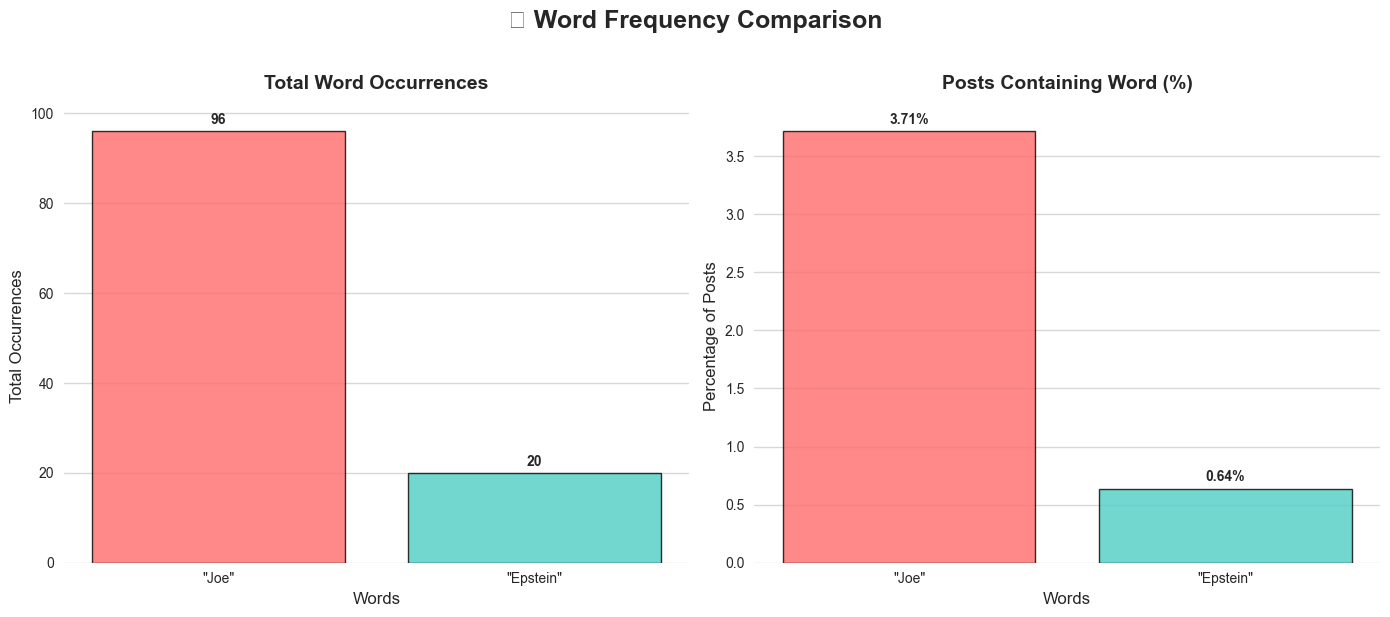

✅ Frequency comparison chart created and saved!


In [34]:
# Create frequency comparison chart
print("📊 Creating frequency comparison chart...")

def create_frequency_comparison(word_analyses):
    """Create bar chart comparing word frequencies using matplotlib"""
    
    # Prepare data
    words = []
    total_occurrences = []
    posts_with_word = []
    percentages = []
    
    for word, analysis in word_analyses.items():
        words.append(f'"{word}"')
        total_occurrences.append(analysis['total_occurrences'])
        posts_with_word.append(analysis['posts_with_word'])
        percentages.append(analysis['posts_with_word']/len(text_df)*100)
    
    if not words:
        print("⚠️ No frequency data to plot")
        return False
    
    # Create matplotlib figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    # Total occurrences chart
    bars1 = ax1.bar(words, total_occurrences, 
                    color=[colors[i % len(colors)] for i in range(len(words))],
                    alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add value labels on bars
    for bar, value in zip(bars1, total_occurrences):
        if value > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., value + max(total_occurrences) * 0.01,
                    f'{int(value)}', ha='center', va='bottom', fontweight='bold')
    
    ax1.set_facecolor('none')
    ax1.set_title('Total Word Occurrences', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Words', fontsize=12)
    ax1.set_ylabel('Total Occurrences', fontsize=12)
    ax1.grid(axis='y', color='gray', alpha=0.3)
    
    # Percentage of posts chart
    bars2 = ax2.bar(words, percentages,
                    color=[colors[i % len(colors)] for i in range(len(words))],
                    alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add value labels on bars
    for bar, value in zip(bars2, percentages):
        if value > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., value + max(percentages) * 0.01,
                    f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_facecolor('none')
    ax2.set_title('Posts Containing Word (%)', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Words', fontsize=12)
    ax2.set_ylabel('Percentage of Posts', fontsize=12)
    ax2.grid(axis='y', color='gray', alpha=0.3)
    
    # Overall title
    fig.suptitle('📊 Word Frequency Comparison', fontsize=18, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.savefig('../images/word_frequency_comparison.svg', format='svg', bbox_inches='tight', dpi=300)
    plt.show()
    
    return True

# Create and show frequency comparison
freq_created = create_frequency_comparison(word_analyses)
if freq_created:
    print("✅ Frequency comparison chart created and saved!")


In [35]:
# Save results and create summary report
print("💾 Saving results...")

# Create detailed results DataFrame
results_data = []

for word, analysis in word_analyses.items():
    for post_data in analysis['posts_data']:
        for context in post_data['contexts']:
            results_data.append({
                'word': word,
                'date': post_data['date'],
                'speaker': post_data['speaker'],
                'context': context['context'],
                'highlighted_context': context['highlighted_context'],
                'position': context['position'],
                'post_content': post_data['content']
            })

# Save detailed results
if results_data:
    results_df = pd.DataFrame(results_data)
    results_df.to_csv('../data/word_frequency_analysis_detailed_fixed.csv', index=False)
    print("✅ Detailed results saved to '../data/word_frequency_analysis_detailed_fixed.csv'")

# Timeline and frequency plots are automatically saved as SVG files by matplotlib
print("✅ Visualizations saved as SVG files in '../images/' directory")

# Create summary report
import json

summary_report = {
    'analysis_date': datetime.now().isoformat(),
    'dataset_info': {
        'total_posts': len(text_df),
        'date_range': {
            'start': text_df['date_parsed'].min().isoformat(),
            'end': text_df['date_parsed'].max().isoformat()
        }
    },
    'target_words': TARGET_WORDS,
    'results': {}
}

for word, analysis in word_analyses.items():
    summary_report['results'][word] = {
        'total_occurrences': analysis['total_occurrences'],
        'posts_with_word': analysis['posts_with_word'],
        'percentage_of_posts': analysis['posts_with_word']/len(text_df)*100,
        'average_per_post': np.mean(analysis['occurrences_per_post']) if analysis['occurrences_per_post'] else 0,
        'max_per_post': max(analysis['occurrences_per_post']) if analysis['occurrences_per_post'] else 0,
        'first_occurrence': min([p['date'] for p in analysis['posts_data']]).isoformat() if analysis['posts_data'] else None,
        'last_occurrence': max([p['date'] for p in analysis['posts_data']]).isoformat() if analysis['posts_data'] else None,
        'monthly_distribution': {k: v for k, v in analysis['monthly_counts'].items()}
    }

# Save summary report
with open('../data/word_frequency_summary_fixed.json', 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)

print("✅ Summary report saved to '../data/word_frequency_summary_fixed.json'")

print("\n🎉 FIXED WORD FREQUENCY ANALYSIS COMPLETE!")
print("="*60)
print("📁 Files generated:")
print("   📊 word_frequency_analysis_detailed_fixed.csv - All occurrences with context")
print("   📈 word_frequency_timeline_fixed.svg - FIXED timeline visualization") 
print("   📊 word_frequency_comparison_fixed.svg - Frequency comparison chart")
print("   📋 word_frequency_summary_fixed.json - Summary statistics")
print("\n🔧 BUG FIXED: Monthly bars now correctly aligned to calendar months!")
print("🖼️ Static SVG visualizations saved and displayed above!")


💾 Saving results...
✅ Detailed results saved to '../data/word_frequency_analysis_detailed_fixed.csv'
✅ Visualizations saved as SVG files in '../images/' directory
✅ Summary report saved to '../data/word_frequency_summary_fixed.json'

🎉 FIXED WORD FREQUENCY ANALYSIS COMPLETE!
📁 Files generated:
   📊 word_frequency_analysis_detailed_fixed.csv - All occurrences with context
   📈 word_frequency_timeline_fixed.svg - FIXED timeline visualization
   📊 word_frequency_comparison_fixed.svg - Frequency comparison chart
   📋 word_frequency_summary_fixed.json - Summary statistics

🔧 BUG FIXED: Monthly bars now correctly aligned to calendar months!
🖼️ Static SVG visualizations saved and displayed above!
